<a href="https://colab.research.google.com/github/annasvenbro/etudesnordiques/blob/main/Test_traductions_fre_swe_API_SRU_BnF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Requêter l'API SRU du Catalogue général de la BnF pour analyser la réception des ouvrages suédois en traduction française depuis 1868

Contrairement à Libris qui renvoie du JSON, le serveur SRU du Catalogue général de la BnF retourne du xml. Il faut donc procéder autrement qu'avec Libris...

##Import des paquets nécessaires

In [ ]:
import requests as rq
from bs4 import BeautifulSoup as bs
import pandas as pd

##Première requête : on veut savoir combien d'ouvrages en français (101 @a fre en Unimarc) traduits du suédois (101 @c swe en Unimarc) datant de 1910 (par exemple) sont présents dans les collections ded la BnF

In [ ]:
url_1910=rq.get("https://catalogue.bnf.fr/api/SRU?version=1.2&operation=searchRetrieve&query=(bib.language%20all%20%22swe%22)%20and%20(bib.language%20all%20%22fre%22)%20and%20(bib.publicationdate%20all%20%221910%22)&recordSchema=unimarcXchange&maximumRecords=1000&startRecord=1")#On requête tous les ouvrages avec des codes de langue francais et suédois datant de 1910 dans l'API de la BnF.
url_1910.content #On affiche le flux xml correspondant.

In [ ]:
soupe_1910=bs(url_1910.text,"xml") #On parse ce flux xml.

In [ ]:
records_1910=soupe_1910.find_all("srw:record")#On trouve les notices correspondantes.

In [ ]:
compteur_1910=0 #On créé et on initialise le compteur
for record in records_1910: #On boucle pour incrémenter le compteur en fonction du nombre de balises <records/> trouvées remplissant la condition définie.
    datafields=record.find_all("mxc:datafield",tag="101",ind1="1",ind2=" ")
    for datafield in datafields:
        subfields=datafield.find_all("mxc:subfield",code="a")
        for subfield in subfields:
            if subfield.text=="fre":
                subfield_c=datafield.find("mxc:subfield",code="c")
                if subfield_c and subfield_c.text=="swe":
                    compteur_1910+=1

print("Nombre de traductions du suédois pour 1910 :",compteur_1910)

Nombre de traductions du suédois pour 1910 : 2


##Fonction : on veut requêter le nombre d'ouvrages suédois traduits en français quelle que soit l'année

In [ ]:
def get_bnf(annee):
  url=rq.get(f"https://catalogue.bnf.fr/api/SRU?version=1.2&operation=searchRetrieve&query=(bib.language%20all%20%22swe%22)%20and%20(bib.language%20all%20%22fre%22)%20and%20(bib.publicationdate%20all%20%22{annee}%22)&recordSchema=unimarcXchange&maximumRecords=1000&startRecord=1")#On insère la variable annee dans une f-string avec l'API.
  soupe=bs(url.text,"xml")#On parse et on construit le compteur comme tout à l'heure.
  records=soupe.find_all("srw:record")
  compteur=0 
  for record in records: #On boucle pour incrémenter le compteur en fonction du nombre de balises <records/> trouvées remplissant la condition définie.
    datafields=record.find_all("mxc:datafield",tag="101",ind1="1",ind2=" ")
    for datafield in datafields:
        subfields=datafield.find_all("mxc:subfield",code="a")
        for subfield in subfields:
            if subfield.text=="fre":
                subfield_c=datafield.find("mxc:subfield",code="c")
                if subfield_c and subfield_c.text=="swe":
                    compteur+=1
  return compteur

In [ ]:
get_bnf(1979) #On teste pour 1979.

19

##On va étudier l'évolution du nombre de publications françaises présentes dans le catalogue général de la BnF depuis une date donnée (par exemple la date du don Dezos de la Roquette)

Warning !!! La requête pour créer le dictionnaire meut mouliner une bonne dizaine de minutes...

In [ ]:
dict_bnf={} #Comme avec Suecana, on crée une variable (un dictionnaire) pour avoir les résultats de la requête par année. On l'initialise d'abord.
for annee in range(1868,2023) : #On fait une boucle en for en fonction de l'année (de 1990 jusqu'à 2023-1=2022).
  publications=get_bnf(annee)
  dict_bnf[annee]=publications#On construit notre dictionnaire par année.

In [ ]:
dict_bnf #On affice le résultat.

In [ ]:
df_bnf = pd.DataFrame.from_dict([dict_bnf]) #On transforme ce dictionnaire en dataframe.
df_bnf #On affiche le dataframe.

In [ ]:
df_bnf=df_bnf.transpose() #Mêmes manips que pour le dataframe issu de l'API de Libris requêtant Suecana.
df_bnf

In [ ]:
df_bnf=df_bnf.rename_axis("Date").reset_index()
df_bnf=df_bnf.set_index("Date")
df_bnf.columns=["Traductions"]
df_bnf

,Traductions
Date,
1868,1
1869,0
1870,0
1871,0
1872,0
...,...
2018,121
2019,145
2020,82


##Représentation graphique

In [ ]:
from pandas import plotting

<Axes: title={'center': 'Les traductions du suédois vers le français dans le Catalogue général de la BnF'}, xlabel='Date'>

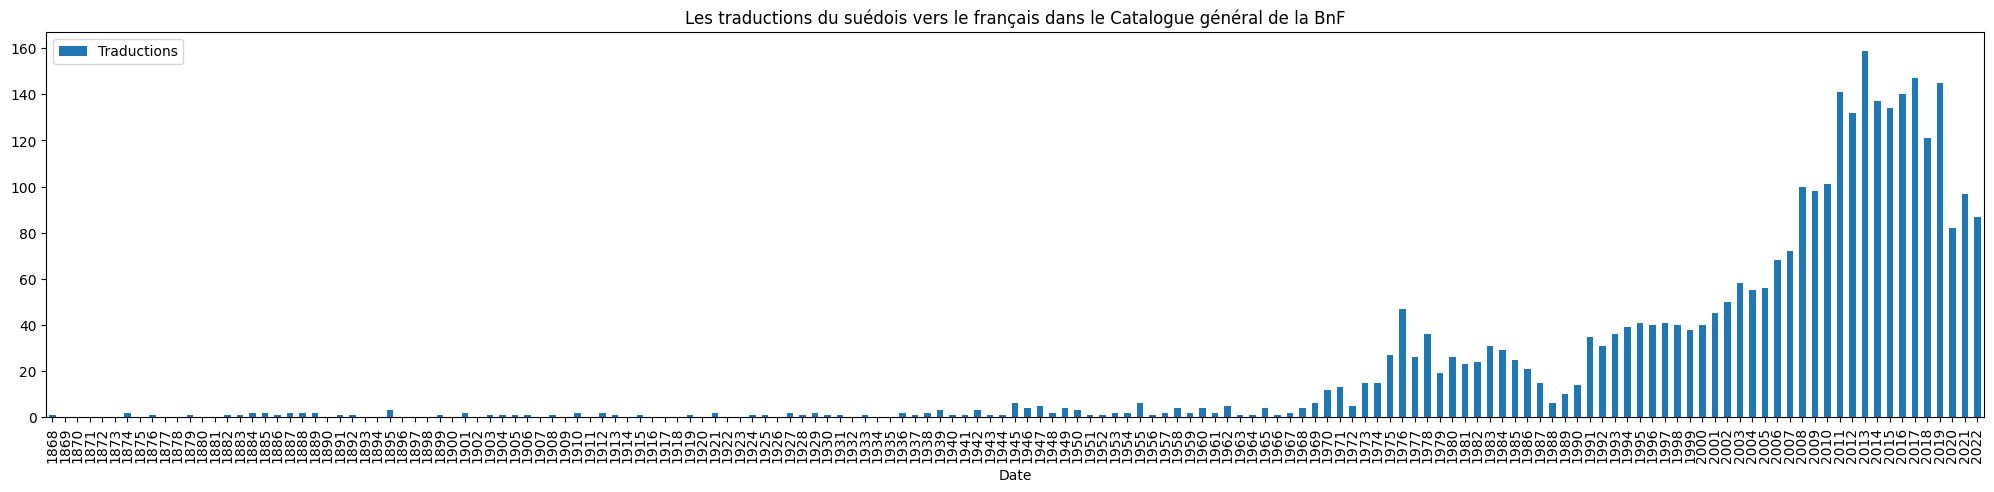

In [63]:
df_bnf.plot(figsize=(25,5),kind="bar",title="Les traductions du suédois vers le français dans le Catalogue général de la BnF")